In [1]:
import re
import string
import glob

import os
import sys
import pandas as pd
import numpy as np
# import gensim
import zipfile
import urllib.request
import tensorflow as tf

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import joblib
import pandas as pd

from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# import spacy
import nltk

sys.path.append(os.path.abspath('..'))
from text_processing_utils import preprocess_text

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense

output_dir = "../data/sentiment140"
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

2023-10-04 12:57:57.676841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /Users/drainasr-
[nltk_data]     edine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/drainasr-
[nltk_data]     edine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/drainasr-
[nltk_data]     edine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Use glob to get a list of CSV files in the directory
csv_files = glob.glob(f'{output_dir}/*.csv')

# Now, csv_files contains a list of paths to all CSV files in the directory
for csv_file in csv_files:
    print(csv_file)

../data/sentiment140/debug16000.csv
../data/sentiment140/debug1600.csv
../data/sentiment140/training.1600000.processed.noemoticon.csv
../data/sentiment140/debug.csv
../data/sentiment140/debug160000.csv


In [3]:
# Read the CSV file into a DataFrame with the specified encoding and column names
df = pd.read_csv(csv_files[0], encoding=DATASET_ENCODING)
# df = pd.read_csv(csv_files[0], encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Display the first few rows of the DataFrame to check the data
df.head(3)


,target,ids,date,flag,user,text
0,4,1957099063,Thu May 28 23:30:53 PDT 2009,NO_QUERY,Dopplertom,@addyx21 My imaginary girlfriend and We Harras...
1,0,2063777023,Sun Jun 07 04:01:58 PDT 2009,NO_QUERY,anapostrero,"hey stephen, i miss you and your undershirt a..."
2,0,1996566132,Mon Jun 01 15:18:05 PDT 2009,NO_QUERY,ayaueda,ya no pude ver el zapping zone completo... ashsh


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  16000 non-null  int64 
 1   ids     16000 non-null  int64 
 2   date    16000 non-null  object
 3   flag    16000 non-null  object
 4   user    16000 non-null  object
 5   text    16000 non-null  object
dtypes: int64(2), object(4)
memory usage: 750.1+ KB


In [5]:
df["target"] = df["target"].replace(4, 1)
df['text'] = df['text'].apply(preprocess_text)
df = df[['text', 'target']]

In [6]:
df.head(10)

,text,target
0,imaginary girlfriend harrassing people class lmao,1
1,hey stephen miss undershirt ohso kewl shoe,0
2,ya pude ver el zapping zone completo ashsh,0
3,morning everyone,1
4,heyy watchin hill hope jayde worked everythin ...,1
5,yep london week learning bn delicious turkish ...,1
6,wan na see transformer midnight dayum lol,0
7,well fun getting pool ready intense workout ta...,1
8,gave tom bradley high school student cave demo...,1
9,hour nap mean staying late,1


In [7]:
# Save the preprocessed DataFrame to a CSV file
df.to_csv('../data/preprocessed_df16000.csv', index=False)


In [8]:
# Load the preprocessed DataFrame
df = pd.read_csv('../data/preprocessed_df16000.csv')

In [9]:
# Remove rows with NaN values in the text column
df = df.dropna(how='any', subset=['text'])

# Print the DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 15929 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15929 non-null  object
 1   target  15929 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 373.3+ KB


In [10]:
tweet_df = df.copy()

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training (95%) and test (5%) sets
X_train, X_test, y_train, y_test = train_test_split(tweet_df['text'], tweet_df['target'], test_size=0.25, random_state=42)

In [12]:
display(len(X_train))
display(len(X_test))
display(len(y_train))
display(len(y_test))

11946

3983

11946

3983

In [13]:
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)


In [14]:
# Define the URL to download the GloVe word vectors file
glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"

# Define the directory to store the downloaded file and the target file name
download_dir = "../data/glove_download"
zip_file_path = os.path.join(download_dir, "glove.zip")

In [15]:
import os
# Create the download directory if it doesn't exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)


In [16]:
# Download the GloVe zip file
if not os.path.exists(zip_file_path):
    print(f"Downloading GloVe from {glove_url}")
    urllib.request.urlretrieve(glove_url, zip_file_path)
    print("Download complete!")

In [17]:
# Unzip the GloVe zip file
glove_dir = os.path.join(download_dir, "glove")
if not os.path.exists(glove_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)
    print(f"GloVe files extracted to {glove_dir}")

In [18]:
# Get the path to the glove.6B.300d.txt file
glove_file_path = os.path.join(glove_dir, "glove.6B.300d.txt")
# Check if the file exists
if os.path.exists(glove_file_path):
    print(f"Path to GloVe file: {glove_file_path}")
else:
    print("GloVe file not found!")

Path to GloVe file: ../data/glove_download/glove/glove.6B.300d.txt


In [19]:
# Load GloVe word embeddings
# glove_50 = "data/glove_download/glove/glove.6B.50d.txt"
embeddings_dict = {}
with open(glove_file_path, 'r', encoding="utf-8") as f:
    for line in f:
        word, *embedding = line.strip().split()
        embeddings_dict[word] = np.array(embedding, dtype=float)


In [20]:
len(embeddings_dict)

400000

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert the text to sequences of indices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences so all of them have the same length
max_len = 150
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len)

# Save the tokenizer to a file
joblib.dump(tokenizer, '../models/tokenizer.pkl')

['../models/tokenizer.pkl']

In [22]:
from keras.layers import Embedding

# Create an embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
import mlflow

# Check if the experiment exists, and if not, create it
experiment_name = "lstm_model"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)

/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


<Experiment: artifact_location='file:///Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/notebooks/mlruns/533166044865263743', creation_time=1695934009457, experiment_id='533166044865263743', last_update_time=1695934009457, lifecycle_stage='active', name='lstm_model', tags={}>

In [24]:
mlflow.start_run(description="lstm_model")

<ActiveRun: >

In [25]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))


In [43]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 300)          4557600   
                                                                 
 dropout_1 (Dropout)         (None, 150, 300)          0         
                                                                 
 bidirectional (Bidirection  (None, 200)               320800    
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
Total params: 4878802 (18.61 MB)
Trainable params: 321202 (1.23 MB)
Non-trainable params: 4557600 (17.39 MB)
_________________________________________________________________
None


In [26]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          4557600   
                                                                 
 dropout (Dropout)           (None, 150, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 4718202 (18.00 MB)
Trainable params: 160602 (627.35 KB)
Non-trainable params: 4557600 (17.39 MB)
_________________________________________________________________
None


In [44]:
# Train the model
history = model.fit(X_train_seq, y_train_one_hot, epochs=8, batch_size=1024, validation_data=(X_test_seq, y_test_one_hot))


Epoch 1/8
12/12 [==============================] - 115s 9s/step - loss: 0.6691 - accuracy: 0.5902 - val_loss: 0.6238 - val_accuracy: 0.6721
Epoch 2/8
12/12 [==============================] - 89s 7s/step - loss: 0.6181 - accuracy: 0.6638 - val_loss: 0.5932 - val_accuracy: 0.6849
Epoch 3/8
12/12 [==============================] - 79s 7s/step - loss: 0.5947 - accuracy: 0.6853 - val_loss: 0.5721 - val_accuracy: 0.7020
Epoch 4/8
12/12 [==============================] - 78s 7s/step - loss: 0.5897 - accuracy: 0.6858 - val_loss: 0.5665 - val_accuracy: 0.7035
Epoch 5/8
12/12 [==============================] - 78s 7s/step - loss: 0.5834 - accuracy: 0.6952 - val_loss: 0.5692 - val_accuracy: 0.7042
Epoch 6/8
12/12 [==============================] - 80s 7s/step - loss: 0.5778 - accuracy: 0.7007 - val_loss: 0.5639 - val_accuracy: 0.7055
Epoch 7/8
12/12 [==============================] - 78s 6s/step - loss: 0.5751 - accuracy: 0.6969 - val_loss: 0.5598 - val_accuracy: 0.7113
Epoch 8/8
12/12 [=========

In [27]:
# Train the model
history = model.fit(X_train_seq, y_train_one_hot, epochs=8, batch_size=1024, validation_data=(X_test_seq, y_test_one_hot))


Epoch 1/8
12/12 [==============================] - 46s 4s/step - loss: 0.6678 - accuracy: 0.5885 - val_loss: 0.6128 - val_accuracy: 0.6741
Epoch 2/8
12/12 [==============================] - 42s 4s/step - loss: 0.6162 - accuracy: 0.6624 - val_loss: 0.5855 - val_accuracy: 0.6995
Epoch 3/8
12/12 [==============================] - 42s 4s/step - loss: 0.5952 - accuracy: 0.6789 - val_loss: 0.5705 - val_accuracy: 0.7042
Epoch 4/8
12/12 [==============================] - 47s 4s/step - loss: 0.5850 - accuracy: 0.6920 - val_loss: 0.5698 - val_accuracy: 0.6992
Epoch 5/8
12/12 [==============================] - 44s 4s/step - loss: 0.5822 - accuracy: 0.6919 - val_loss: 0.5700 - val_accuracy: 0.7030
Epoch 6/8
12/12 [==============================] - 44s 4s/step - loss: 0.5805 - accuracy: 0.6940 - val_loss: 0.5620 - val_accuracy: 0.7120
Epoch 7/8
12/12 [==============================] - 44s 4s/step - loss: 0.5736 - accuracy: 0.6996 - val_loss: 0.5624 - val_accuracy: 0.7075
Epoch 8/8
12/12 [==========

In [45]:
joblib.dump(model, '../models/lstm_model_glove.pkl')


['../models/lstm_model_glove.pkl']

In [46]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_seq, y_test_one_hot)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Loss: {loss * 100:.2f}%')

125/125 [==============================] - 10s 77ms/step - loss: 0.5583 - accuracy: 0.7108
Accuracy: 71.08%
Loss: 55.83%


125/125 [==============================] - 10s 79ms/step


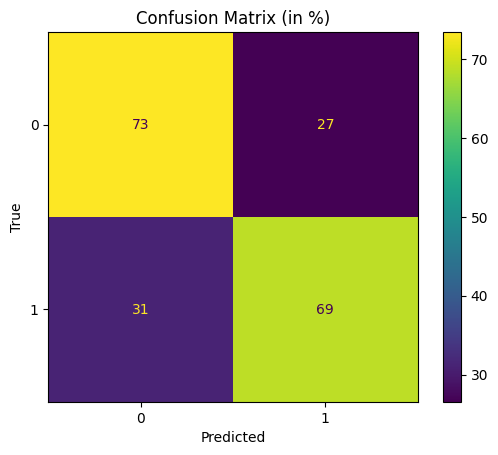

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1989
           1       0.72      0.69      0.70      1994

    accuracy                           0.71      3983
   macro avg       0.71      0.71      0.71      3983
weighted avg       0.71      0.71      0.71      3983



In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Make predictions using your LSTM model
y_pred = model.predict(X_test_seq)

# Convert softmax predictions into categorical labels (0 or 1)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Normalize the confusion matrix to display percentages
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_norm)

# Display the confusion matrix
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (in %)')

# Save the plot as an image (e.g., PNG)
plt.savefig('../imgs/confusion_matrix_plot.png')
mlflow.log_artifact('../imgs/confusion_matrix_plot.png')

# Show the plot
plt.show()

# Calculate other evaluation metrics (optional)
report = classification_report(y_true_labels, y_pred_labels)
print("Classification Report:")
print(report)


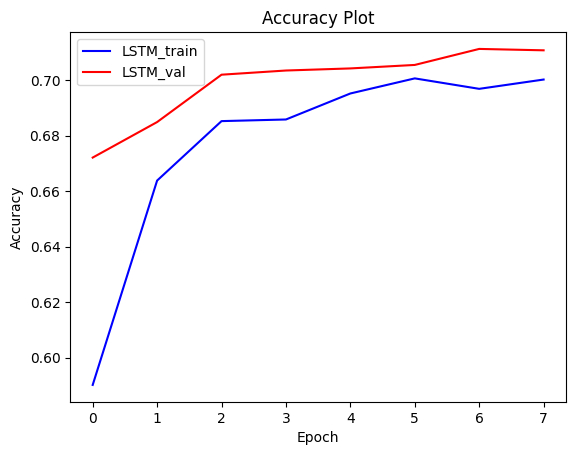

In [48]:
plt.plot(history.history['accuracy'], c= 'b')
plt.plot(history.history['val_accuracy'], c='r')
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['LSTM_train', 'LSTM_val'], loc='upper left')
plt.savefig('../imgs/accuracy_plot.png')
mlflow.log_artifact('../imgs/accuracy_plot.png')

plt.show()


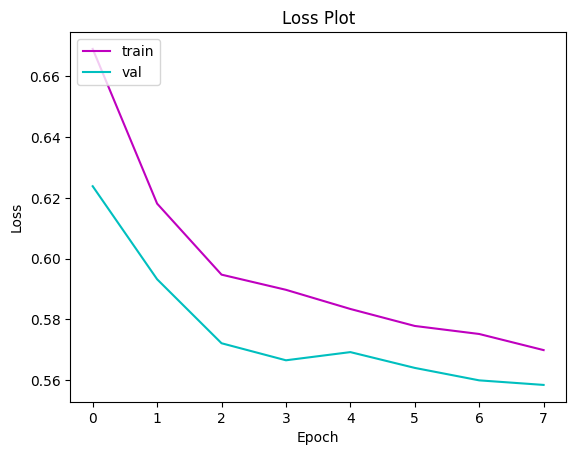

In [49]:

plt.plot(history.history['loss'], c='m')
plt.plot(history.history['val_loss'], c='c')
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.savefig('../imgs/loss_plot.png')
mlflow.log_artifact('../imgs/loss_plot.png')
plt.show()


In [50]:
# Track your experiment with MLflow
mlflow.log_metrics({'accuracy': accuracy})
mlflow.log_metrics({'loss': loss})

In [51]:
# Log hyperparameters
mlflow.log_params({'input_dim': len(word_index), 'output_dim': 300, 'input_length': max_len})
mlflow.log_params({'epochs': 8, 'batch_size': 1024})


In [52]:
# Save the model to a file
mlflow.log_artifact('../models/lstm_model_glove.pkl')

In [53]:
mlflow.end_run()

In [42]:
!mlflow ui

/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
[2023-10-04 13:12:44 +0200] [53109] [INFO] Starting gunicorn 21.2.0
[2023-10-04 13:12:44 +0200] [53109] [INFO] Listening at: http://127.0.0.1:5000 (53109)
[2023-10-04 13:12:44 +0200] [53109] [INFO] Using worker: sync
[2023-10-04 13:12:44 +0200] [53110] [INFO] Booting worker with pid: 53110
[2023-10-04 13:12:44 +0200] [53111] [INFO] Booting worker with pid: 53111
[2023-10-04 13:12